# MLP Classifier

Multi-layer Perceptron Classifier

## Introduction

The scikit-learn library provides an implementation of the Multi-layer Perceptron Classifier. This model is a feedforward neural network and it's perfect for quick prototyping of a neural network model.

## Implementation

In [1]:
# import libraries
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pandas as pd

from sklearn.model_selection import train_test_split
from mlflow.create_dataset import Dataset
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from scipy.stats import uniform

data/df_encoded.csv


Get the data to train the model.

In [2]:
# import dataset
from mlflow.create_dataset import Dataset

data = Dataset()
X, y = data.with_correlation()
output = data.test

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [3]:
# initialize model
model_to_train = MultiOutputClassifier(MLPClassifier(early_stopping=True, solver='adam', learning_rate='constant', batch_size = 64, max_iter=2000), n_jobs=-1)

In [4]:
# initialize search hyperparameters
param_dist = {
    'estimator__hidden_layer_sizes': [
        (100,), (100, 50), (150,100,50), (100, 50, 25)
    ],
    'estimator__activation': ['tanh', 'relu', 'logistic'],
    'estimator__learning_rate_init': [0.0001, 0.001, 0.01],
    'estimator__alpha': [0.0001, 0.001, 0.01],
}

random_search = RandomizedSearchCV(estimator=model_to_train, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=0, scoring = 'roc_auc')

In [5]:
# train model
# WARNING time: 25 minutes
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('Best parameters found by grid search:', random_search.best_params_)

Best parameters found by grid search: {'estimator__learning_rate_init': 0.001, 'estimator__hidden_layer_sizes': (100,), 'estimator__alpha': 0.001, 'estimator__activation': 'tanh'}


In [6]:
# predict on test set
y_pred = best_model.predict(X_test)

In [7]:
################ METRICS ################
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

Accuracy: 0.6793335829277424
ROC AUC: 0.7489302877414762
F1: 0.6746705614884707


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.72      0.50      0.59      1135
           1       0.76      0.76      0.76      2488

   micro avg       0.75      0.68      0.71      3623
   macro avg       0.74      0.63      0.67      3623
weighted avg       0.74      0.68      0.71      3623
 samples avg       0.36      0.34      0.34      3623



In [9]:
# competition submission
predictions = best_model.predict_proba(output)
        
h1n1_probs = predictions[0][:, 1]  # Probabilities of positive class for h1n1_vaccine
seasonal_probs = predictions[1][:, 1]  # Probabilities of positive class for seasonal_vaccine
predict = pd.DataFrame({
            "respondent_id": output.index,
            "h1n1_vaccine": h1n1_probs,
            "seasonal_vaccine": seasonal_probs
})
predict.set_index("respondent_id", inplace=True)
predict.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.110681,0.221165
26708,0.035350,0.046806
26709,0.301699,0.739845
26710,0.633276,0.925289
26711,0.483327,0.545200


Uncomment the following cell to save the results on an csv file to upload it to the competition.

In [10]:
# predict.to_csv("predictions.csv")

## Results

Below, there's an screenshot of the results of multiple runs of the model with mlflow.

![Captura de pantalla 2024-12-24 130532.png](<attachment:Captura de pantalla 2024-12-24 130532.png>)
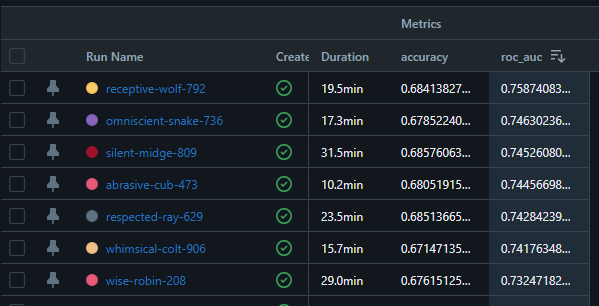

### Best model found

Metrics for our local validation set shows a performance similar but lower than the one with Random Forest Classifier.

![Captura de pantalla 2024-12-24 125728.png](<attachment:Captura de pantalla 2024-12-24 125728.png>)
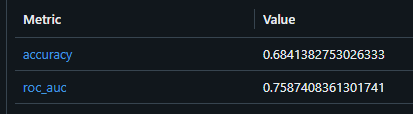

From the picture below we can see the parameters of the best model found, the others are set to default values.
![Captura de pantalla 2024-12-24 125918.png](<attachment:Captura de pantalla 2024-12-24 125918.png>)
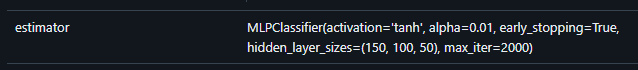

Here's the competition score for this model.   

![Captura de pantalla 2024-12-24 130220.png](<attachment:Captura de pantalla 2024-12-24 130220.png>)
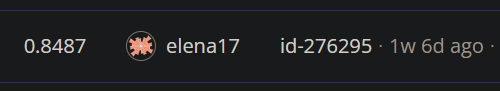

Again, as in the Random Forest Classifier, the model performs better in the competition (with a higher ROC_AUC score) than in the local validation set. This means that the model is generalizing well to the test set.

This aproach is a good one for quick prototyping of a neural network model, but it's not the best one for this competition.